In [1]:
from io import StringIO

import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
from loguru import logger
import yaml

from datetime import datetime
import polars as pl
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# MODEL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler,
    label_binarize
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)

# Save variables for model
import joblib
import json

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# PERSONAL FUNCTIONS
from utils import *
from models.main import *
from models.optimizer import ViterbiLiteDecoder
from functions.windows import create_feature_windows # creación de ventanas e ingenieria de características
from functions.build_window_raw import create_raw_windows_250_timesteps_robust
from functions.multimodal import create_multimodal_windows_robust
from functions.multimodal_dom_temporal_frequence import create_multimodal_windows_with_features

In [2]:
dict_preds = {
    'Eat':      {'y': [], 'y_pred': []},
    'Stand':    {'y': [], 'y_pred': []},
    'Walk':     {'y': [], 'y_pred': []},
    'Sit':      {'y': [], 'y_pred': []},
    'Type':     {'y': [], 'y_pred': []}
}

In [3]:
dic_result = {
            'Eat':      {'Accuracy' : [], 'F1-score': [], 'Precision': [], 'Recall': []}, 
            'Walk':     {'Accuracy' : [], 'F1-score': [], 'Precision': [], 'Recall': []},
            'Sit':      {'Accuracy' : [], 'F1-score': [], 'Precision': [], 'Recall': []},
            'Stand':    {'Accuracy' : [], 'F1-score': [], 'Precision': [], 'Recall': []},
            'Type':     {'Accuracy' : [], 'F1-score': [], 'Precision': [], 'Recall': []}
        }

In [50]:
loaded = tf.saved_model.load(r"F:\UPC\Tesis\HARbit-Model\src\cnn_temporal_20_epochs_95\saved_model")
infer = loaded.signatures["serving_default"]
label_encoder = joblib.load(r'F:\UPC\Tesis\HARbit-Model\src\cnn_temporal_20_epochs_95\label_encoder.joblib')


In [51]:
path_base = r"F:\UPC\Tesis\HARbit-Model\src\data\real-data"
archive_date = [archive for archive in os.listdir(r"F:\UPC\Tesis\HARbit-Model\src\data\real-data") if '.json' not in archive]


for data in archive_date:
    path_data = os.path.join(path_base, data)
    file_data = os.listdir(path_data)

    target = data.split('-')[0].title()
    for file in file_data:

        file_path = os.path.join(path_data, file)
        
        with open(file_path, 'rb') as file:
            data = json.load(file)

        gyro_df = data['gyro']
        accel_df = data['accel']

        accel_temp = pl.DataFrame(accel_df)
        gyro_temp = pl.DataFrame(gyro_df)

        
        accel_temp = accel_temp.with_columns(pl.lit('A').alias('Usuario'))
        gyro_temp  = gyro_temp.with_columns(pl.lit('A').alias('Usuario'))

        accel_temp = accel_temp.with_columns(pl.lit(target).alias('gt'))
        gyro_temp = gyro_temp.with_columns(pl.lit(target).alias('gt'))

        df_accel = normalize_columns(accel_temp,
                            user_col_name  = "Usuario", 
                            timestamp_col_name = "timestamp", 
                            label_col_name = "gt", 
                            x_col_name = "x", 
                            y_col_name = "y", 
                            z_col_name = "z"
                        )

        df_gyro = normalize_columns(gyro_temp, 
                            user_col_name  = "Usuario", 
                            timestamp_col_name = "timestamp", 
                            label_col_name = "gt", 
                            x_col_name = "x", 
                            y_col_name = "y", 
                            z_col_name = "z"
                        )
        
        df_accel = convert_timestamp(df_accel)
        df_gyro = convert_timestamp(df_gyro)

        X_all, y_all, subjects_all, metadata_all = create_multimodal_windows_robust(
            df_accel = df_accel, 
            df_gyro = df_gyro,
            window_seconds=5,
            overlap_percent=50,
            sampling_rate=20,
            target_timesteps=100,
            min_data_threshold=0.8,  # 80% mínimo de datos
            max_gap_seconds=1.0      # Máximo 1 segundo de gap
        )

        X_tensor = tf.constant(X_all, dtype=tf.float32)
        y_pred = infer(X_tensor)
        y_all = label_encoder.transform(y_all)

        # Ejemplo: y_pred con probabilidades
        y_pred_probs = list(y_pred.values())[0].numpy()

        # Convertir a clases predichas (índice del máximo)
        y_pred_classes = np.argmax(y_pred_probs, axis=1)


        # Comparar con y_real (asegúrate de que y_real tenga etiquetas 0..N-1)
        acc = accuracy_score(y_all, y_pred_classes)
        
        precision, recall, f1, _ = precision_recall_fscore_support(
                y_all, y_pred_classes, average='macro', zero_division=0
            )
        
        dic_result[target]['Accuracy'].append(acc*100)
        dic_result[target]['F1-score'].append(f1*100)
        dic_result[target]['Precision'].append(precision*100)
        dic_result[target]['Recall'].append(recall*100)

        dict_preds[target]['y'].extend(y_all)
        dict_preds[target]['y_pred'].extend(y_pred_classes)        

🔧 CONFIGURACIÓN MULTIMODAL (Accel + Gyro):
  Duración: 5s
  Timesteps objetivo: 100
  Canales objetivo: 6
  Frecuencia de muestreo: 20Hz
  Solapamiento: 50%
  Umbral mínimo de datos: 80.0%
  Máximo gap permitido: 1.0s
  Tolerancia sincronización: 50ms
  ACCEL preparado: 6531 muestras
  GYRO preparado: 3769 muestras

🔄 SINCRONIZANDO SENSORES...
  📊 Datos originales:
    Acelerómetro: 6,531 muestras
    Giroscopio: 3,769 muestras
  ⏰ Rango temporal común: 150.0s
  📊 Datos sincronizados:
    Acelerómetro: 6,520 muestras
    Giroscopio: 3,769 muestras

📏 PARÁMETROS TEMPORALES:
  Duración de ventana: 5s
  Paso entre ventanas: 2.50s

👤 Usuario A, Eat:
   Accel: 6520 muestras
   Gyro: 3769 muestras
   ✅ Creadas 58 ventanas válidas

📊 RESUMEN MULTIMODAL:
  Ventanas intentadas: 58
  Ventanas creadas: 58
  Ventanas con gyro: 58
  Ventanas solo accel: 0
  Tasa de éxito: 100.0%

✅ RESULTADO FINAL MULTIMODAL:
  Forma de X: (58, 100, 6) (samples, timesteps, channels)
  Canales: 6 (accel_xyz + gyro_x

In [52]:
for activity in dict_preds.keys():

    y_true = dict_preds[activity]['y']
    y_pred = dict_preds[activity]['y_pred']
    
    acc = accuracy_score(y_true, y_pred)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0
        )
    print(f"{activity}")
    print(f"Accuracy: {acc*100}")
    print(f"F1-score: {f1*100}")
    print(f"Precision: {precision*100}")
    print(f"Recall: {recall*100}")
    print("-" * 50)

Eat
Accuracy: 76.92307692307693
F1-score: 17.391304347826086
Precision: 20.0
Recall: 15.384615384615385
--------------------------------------------------
Stand
Accuracy: 0.0
F1-score: 0.0
Precision: 0.0
Recall: 0.0
--------------------------------------------------
Walk
Accuracy: 93.50785340314135
F1-score: 19.329004329004327
Precision: 20.0
Recall: 18.701570680628272
--------------------------------------------------
Sit
Accuracy: 96.74418604651163
F1-score: 32.781717888100864
Precision: 33.33333333333333
Recall: 32.248062015503876
--------------------------------------------------
Type
Accuracy: 96.63299663299664
F1-score: 49.14383561643836
Precision: 50.0
Recall: 48.31649831649832
--------------------------------------------------


In [53]:
from sklearn.metrics import classification_report

y_true_global = []
y_pred_global = []

for activity in dict_preds.keys():
    y_true_global.extend(dict_preds[activity]['y'])
    y_pred_global.extend(dict_preds[activity]['y_pred'])

labels = np.unique(y_true_global)  # clases presentes en los datos
target_names = label_encoder.inverse_transform(labels)

print(classification_report(
    y_true_global, y_pred_global,
    labels=labels,
    target_names=target_names
))

              precision    recall  f1-score   support

         Eat       0.21      0.77      0.33       130
         Sit       0.85      0.97      0.91       215
       Stand       0.00      0.00      0.00       372
        Type       0.98      0.97      0.97       297
        Walk       0.99      0.94      0.96       955

   micro avg       0.78      0.76      0.77      1969
   macro avg       0.61      0.73      0.63      1969
weighted avg       0.74      0.76      0.73      1969



In [54]:
with open(r"F:\UPC\Tesis\HARbit-Model\src\data\real-data\stand-data\stand_left_10.json", 'rb') as file:
    data = json.load(file)

gyro_df = data['gyro']
accel_df = data['accel']

accel_temp = pl.DataFrame(accel_df)
gyro_temp = pl.DataFrame(gyro_df)
        
accel_temp = accel_temp.with_columns(pl.lit('A').alias('Usuario'))
gyro_temp  = gyro_temp.with_columns(pl.lit('A').alias('Usuario'))

accel_temp = accel_temp.with_columns(pl.lit("Stand").alias('gt'))
gyro_temp = gyro_temp.with_columns(pl.lit("Stand").alias('gt'))

df_accel = normalize_columns(accel_temp,
                    user_col_name  = "Usuario", 
                    timestamp_col_name = "timestamp", 
                    label_col_name = "gt", 
                    x_col_name = "x", 
                    y_col_name = "y", 
                    z_col_name = "z"
                )

df_gyro = normalize_columns(gyro_temp, 
                    user_col_name  = "Usuario", 
                    timestamp_col_name = "timestamp", 
                    label_col_name = "gt", 
                    x_col_name = "x", 
                    y_col_name = "y", 
                    z_col_name = "z"
                )
        
df_accel = convert_timestamp(df_accel)
df_gyro = convert_timestamp(df_gyro)

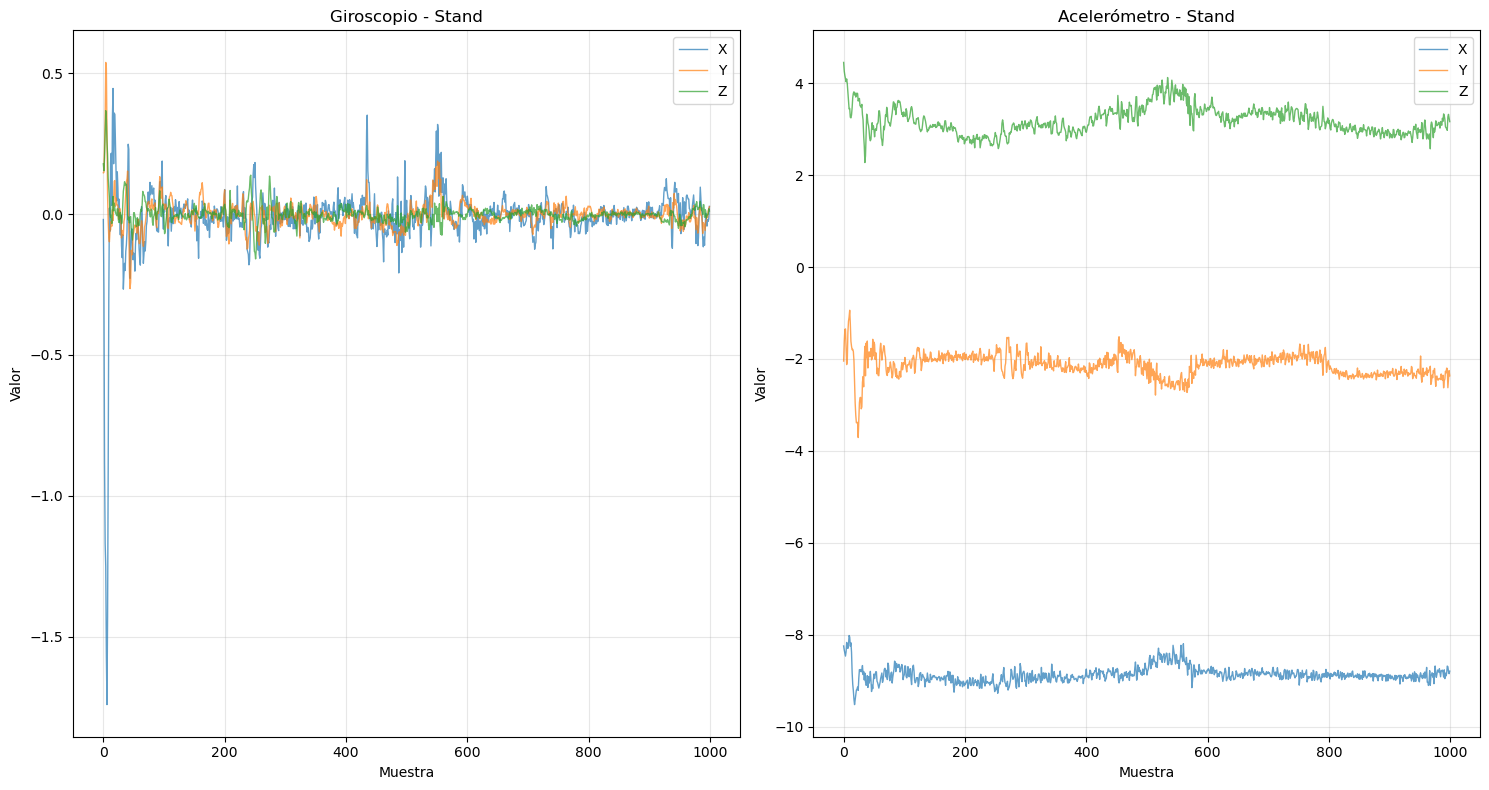

In [55]:
def plot_axes_by_activity(df_gyro, df_accel, 
                          max_samples_per_activity = 1000, 
                          figsize = (15, 12), 
                          id_user = 'A'):
    """
    Visualiza los ejes X, Y, Z del giroscopio y acelerómetro por cada actividad
    """

    df_gyro  = df_gyro[df_gyro['Subject-id']   == id_user]
    df_accel = df_accel[df_accel['Subject-id'] == id_user]

    # Obtener actividades únicas
    activities = df_gyro['Activity Label'].unique().tolist()
    n_activities = len(activities)
    
    # Crear subplots
    fig, axes = plt.subplots(n_activities, 2, figsize=figsize)
    if n_activities == 1:
        axes = axes.reshape(1, -1)
    
    for i, activity in enumerate(activities):
        # Filtrar datos por actividad
        gyro_activity = df_gyro[df_gyro['Activity Label'] == activity]
        accel_activity =  df_accel[df_accel['Activity Label'] == activity]
        
        # Limitar muestras para mejor visualización
        if len(gyro_activity) > max_samples_per_activity:
            gyro_activity = gyro_activity.head(max_samples_per_activity)
        if len(accel_activity) > max_samples_per_activity:
            accel_activity = accel_activity.head(max_samples_per_activity)
        
        # Convertir a pandas para plotting
        gyro_pd = gyro_activity.copy()
        accel_pd = accel_activity.copy()
        
        # Plot Giroscopio
        axes[i, 0].plot(gyro_pd['X'], label='X', alpha=0.7, linewidth=1)
        axes[i, 0].plot(gyro_pd['Y'], label='Y', alpha=0.7, linewidth=1)
        axes[i, 0].plot(gyro_pd['Z'], label='Z', alpha=0.7, linewidth=1)
        axes[i, 0].set_title(f'Giroscopio - {activity}')
        axes[i, 0].set_ylabel('Valor')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot Acelerómetro
        axes[i, 1].plot(accel_pd['X'], label='X', alpha=0.7, linewidth=1)
        axes[i, 1].plot(accel_pd['Y'], label='Y', alpha=0.7, linewidth=1)
        axes[i, 1].plot(accel_pd['Z'], label='Z', alpha=0.7, linewidth=1)
        axes[i, 1].set_title(f'Acelerómetro - {activity}')
        axes[i, 1].set_ylabel('Valor')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)
        
        # Añadir xlabel solo en la última fila
        if i == n_activities - 1:
            axes[i, 0].set_xlabel('Muestra')
            axes[i, 1].set_xlabel('Muestra')
    
    plt.tight_layout()
    plt.show()

# Ejecutar visualización
plot_axes_by_activity(df_gyro.to_pandas(), df_accel.to_pandas(),figsize = (15, 8), id_user = "A")

In [20]:
accuracy_score(y_true_global, y_pred_global) * 100

80.54080154514726

In [2]:
path_base = r"F:\UPC\Tesis\HARbit-Model\src\data\wisdm-dataset\raw\watch"
sensor_data = load_sensors_separately(path_base)
df_gyro = sensor_data['gyro']
# df_gyro = df_gyro.rename({'X': 'X_gyro', 'Y': 'Y_gyro', 'Z': 'Z_gyro'})

df_accel = sensor_data['accel']
# df_accel = df_accel.rename({'X': 'X_accel', 'Y': 'Y_accel', 'Z': 'Z_accel'})

print(f"Giroscopio: {len(df_gyro)} muestras")
print(f"Acelerómetro: {len(df_accel)} muestras")

2025-09-30 21:58:31.517 | INFO     | utils.data_loading:load_sensors_separately:64 - Cargando datos de gyro...
2025-09-30 21:58:42.127 | INFO     | utils.data_loading:load_sensors_separately:64 - Cargando datos de accel...


Giroscopio: 3440341 muestras
Acelerómetro: 3777045 muestras


In [ ]:
X_raw, X_features, y, subjects, metadata = create_multimodal_windows_with_features(
            df_accel = df_accel, 
            df_gyro = df_gyro,
            window_seconds = 5,
            overlap_percent = 50,
            sampling_rate = 20,
            target_timesteps = 100,
            min_data_threshold = 0.8,  # 80% mínimo de datos
            max_gap_seconds = 1.0,      # Máximo 1 segundo de gap
            extract_features = True  # ← Activar extracción de características
        )

🔧 CONFIGURACIÓN MULTIMODAL (Accel + Gyro):
  Duración: 5s
  Timesteps objetivo: 100
  Canales objetivo: 6
  Frecuencia de muestreo: 20Hz
  Solapamiento: 50%
  Umbral mínimo de datos: 80.0%
  Máximo gap permitido: 1.0s
  Tolerancia sincronización: 50ms
  ACCEL preparado: 3777045 muestras
  GYRO preparado: 3440341 muestras

🔄 SINCRONIZANDO SENSORES...
  📊 Datos originales:
    Acelerómetro: 3,777,045 muestras
    Giroscopio: 3,440,341 muestras
  ⏰ Rango temporal común: 2722977.0s
  📊 Datos sincronizados:
    Acelerómetro: 3,777,043 muestras
    Giroscopio: 3,440,341 muestras

📏 PARÁMETROS TEMPORALES:
  Duración de ventana: 5s
  Paso entre ventanas: 2.50s

👤 Usuario 1600.0, A:
   Accel: 3604 muestras
   Gyro: 3602 muestras
   ✅ Creadas 70 ventanas válidas

👤 Usuario 1600.0, B:
   Accel: 3605 muestras
   Gyro: 3604 muestras
   ✅ Creadas 70 ventanas válidas

👤 Usuario 1600.0, C:
   Accel: 3605 muestras
   Gyro: 3604 muestras
   ✅ Creadas 70 ventanas válidas

👤 Usuario 1600.0, D:
   Accel: 3

In [12]:
X_acc, y_acc, subjects_acc, metadata_acc = create_raw_windows_250_timesteps_robust(
            df=df_accelerometer,
            window_seconds=5,
            overlap_percent=50,
            sampling_rate=20,
            target_timesteps=100,
            min_data_threshold=0.8,  # 80% mínimo de datos
            max_gap_seconds=1.0      # Máximo 1 segundo de gap
        )

🔧 Configuración de ventanas RAW ROBUSTA:
  Duración: 5s
  Timesteps objetivo: 100
  Frecuencia de muestreo: 20Hz
  Solapamiento: 50%
  Umbral mínimo de datos: 80.0%
  Máximo gap permitido: 1.0s
  Duración de ventana: 5s
  Paso entre ventanas: 2.50s
👤 Usuario 1600.0, Actividad A: 3604 muestras
   Duración total: 179.8s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad B: 3605 muestras
   Duración total: 179.9s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad C: 3605 muestras
   Duración total: 179.8s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad D: 3606 muestras
   Duración total: 179.9s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad E: 3605 muestras
   Duración total: 179.9s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad F: 3605 muestras
   Duración total: 179.9s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad G: 3604 muestras
   Duración total: 179.8s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad H:

In [155]:
X_gyro, y_gyro, subjects_gyro, metadata_gyro = create_raw_windows_250_timesteps_robust(
            df=df_gyroscope,
            window_seconds=5,
            overlap_percent=50,
            sampling_rate=20,
            target_timesteps=100,
            min_data_threshold=0.8,  # 80% mínimo de datos
            max_gap_seconds=1.0      # Máximo 1 segundo de gap
        )

🔧 Configuración de ventanas RAW ROBUSTA:
  Duración: 5s
  Timesteps objetivo: 100
  Frecuencia de muestreo: 20Hz
  Solapamiento: 50%
  Umbral mínimo de datos: 80.0%
  Máximo gap permitido: 1.0s
  Duración de ventana: 5s
  Paso entre ventanas: 2.50s
👤 Usuario 1600.0, Actividad A: 3602 muestras
   Duración total: 179.7s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad B: 3604 muestras
   Duración total: 179.8s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad C: 3604 muestras
   Duración total: 179.8s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad D: 3604 muestras
   Duración total: 179.8s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad E: 3604 muestras
   Duración total: 179.9s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad F: 3604 muestras
   Duración total: 179.9s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad G: 3603 muestras
   Duración total: 179.8s
  ✅ Creadas 70 ventanas válidas
👤 Usuario 1600.0, Actividad H:

In [8]:
X_all, y_all, subjects_all, metadata_all = create_multimodal_windows_robust(
            df_accel = df_accelerometer, 
            df_gyro = df_gyroscope,
            window_seconds=5,
            overlap_percent=50,
            sampling_rate=20,
            target_timesteps=100,
            min_data_threshold=0.8,  # 80% mínimo de datos
            max_gap_seconds=1.0      # Máximo 1 segundo de gap
        )

🔧 CONFIGURACIÓN MULTIMODAL (Accel + Gyro):
  Duración: 5s
  Timesteps objetivo: 100
  Canales objetivo: 6
  Frecuencia de muestreo: 20Hz
  Solapamiento: 50%
  Umbral mínimo de datos: 80.0%
  Máximo gap permitido: 1.0s
  Tolerancia sincronización: 50ms
  ACCEL preparado: 3777045 muestras
  GYRO preparado: 3440341 muestras

🔄 SINCRONIZANDO SENSORES...
  📊 Datos originales:
    Acelerómetro: 3,777,045 muestras
    Giroscopio: 3,440,341 muestras
  ⏰ Rango temporal común: 2722977.0s
  📊 Datos sincronizados:
    Acelerómetro: 3,777,043 muestras
    Giroscopio: 3,440,341 muestras

📏 PARÁMETROS TEMPORALES:
  Duración de ventana: 5s
  Paso entre ventanas: 2.50s

👤 Usuario 1600.0, A:
   Accel: 3604 muestras
   Gyro: 3602 muestras
   ✅ Creadas 70 ventanas válidas

👤 Usuario 1600.0, B:
   Accel: 3605 muestras
   Gyro: 3604 muestras
   ✅ Creadas 70 ventanas válidas

👤 Usuario 1600.0, C:
   Accel: 3605 muestras
   Gyro: 3604 muestras
   ✅ Creadas 70 ventanas válidas

👤 Usuario 1600.0, D:
   Accel: 3